# Assignment 5

### <span style="color:chocolate"> Submission requirements </span>

Your work will not be graded if your notebook doesn't include output. In other words, <span style="color:red"> make sure to rerun your notebook before submitting to Gradescope </span> (Note: if you are using Google Colab: go to Edit > Notebook Settings  and uncheck Omit code cell output when saving this notebook, otherwise the output is not printed).

Additional points may be deducted if these requirements are not met:
    
* Comment your code;
* Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own;
* Try and minimize the use of the global namespace (meaning, keep things inside functions).

Additional notes:

* Please note that in this assignment, students are expected to work independently. As a result, no two solutions should look identical in terms of coding;
* You may import any libraries you need to complete the assignment. However, you must implement the model using TensorFlow (do not use PyTorch);
* Follow the same steps/idea as in Assignment 4; the difference here is that you extend a logistic model to more than two classes;
* <span style="color:chocolate"> Focus on the execution of the task rather than model performance </span> (this is how the TA will grade your work);
* Even though the prediction performance for your chosen outcome is low, it doesn't necessarily mean there is something wrong with your implementation. It could also be that the data is not supportive enough for your prediction task... again, focus on the learning opportunity and not the numbers you get;
* Your instructional team has extensive experience developing and running ML models. Often, we encounter situations where a model doesn't perform well on a predictive task. This can happen due to the nature of the data or the need for significant tweaking of variables to achieve good results;
* Do not spend significantly more time on this task than you did on Assignment 4, unless you wish to experiment and learn more.
---

``Objective``
* Perform multiclass classification using logistic regression. <span style="color:chocolate"> You will choose the outcome of interest. </span>

``Motivation``
* Chocolate is one of the most popular candies in the world. Each year, residents of the United States collectively eat more than 2.8 billions pounds (Source: Kaggle). However, not all chocolate bars are created equal! In this assignment, you will have the opportunity to delve into the world of chocolate by choosing your own machine learning task. 


``Data``

* The [Chocolate Bar dataset](https://www.kaggle.com/datasets/rtatman/chocolate-bar-ratings) contains expert ratings of 1,795 individual chocolate bars, along with information on their regional origin, percentage of cocoa, the variety of chocolate bean used and where the beans were grown (Source: Kaggle).

### Import libraries

In [1]:
%reset -f
from __future__ import print_function

import math
import numpy as np
import numpy.linalg as nla
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import six
from os.path import join
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from keras_tuner import HyperParameters

# feel free to import other libraries as needed

import warnings
warnings.filterwarnings('ignore')

2024-10-07 00:42:57.126424: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-07 00:42:57.180039: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-07 00:42:57.193318: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-07 00:42:57.286860: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-07 00:42:58.582944: W tensorflow/compiler/tf2

### Define functions

In [2]:
def read_data():
    ''''''
    # Read data
    df = pd.read_csv(
        "https://download.mlcc.google.com/mledu-datasets/flavors_of_cacao.csv",
        sep=",",
        encoding='latin-1'
    )
    
    return df

In [3]:
def clean_data(df):
    ''''''
    # Set the output display to have one digit for decimal places and limit it to
    # printing 15 rows.
    pd.options.display.float_format = '{:.2f}'.format
    pd.options.display.max_rows = 15
    
    # Rename the columns.
    df.columns = [
        'maker', 'specific_origin', 'reference_number',
        'review_date', 'cocoa_percent', 'maker_location',
        'rating', 'bean_type', 'broad_origin'
    ]

    # df.dtypes

    # Replace empty/null values with "Blend"
    df['bean_type'] = df['bean_type'].fillna('Blend')

    # Cast bean_type to string to remove leading 'u'
    df['bean_type'] = df['bean_type'].astype(str)
    df['cocoa_percent'] = df['cocoa_percent'].str.strip('%')
    df['cocoa_percent'] = pd.to_numeric(df['cocoa_percent'])

    # Correct spelling mistakes, and replace city with country name
    df['maker_location'] = df['maker_location']\
    .str.replace('Amsterdam', 'Holland')\
    .str.replace('U.K.', 'England')\
    .str.replace('Niacragua', 'Nicaragua')\
    .str.replace('Domincan Republic', 'Dominican Republic')

    # Adding this so that Holland and Netherlands map to the same country.
    df['maker_location'] = df['maker_location']\
    .str.replace('Holland', 'Netherlands')

    def cleanup_spelling_abbrev(text):
        replacements = [
            ['-', ', '], ['/ ', ', '], ['/', ', '], ['\(', ', '], [' and', ', '], [' &', ', '], ['\)', ''],
            ['Dom Rep|DR|Domin Rep|Dominican Rep,|Domincan Republic', 'Dominican Republic'],
            ['Mad,|Mad$', 'Madagascar, '],
            ['PNG', 'Papua New Guinea, '],
            ['Guat,|Guat$', 'Guatemala, '],
            ['Ven,|Ven$|Venez,|Venez$', 'Venezuela, '],
            ['Ecu,|Ecu$|Ecuad,|Ecuad$', 'Ecuador, '],
            ['Nic,|Nic$', 'Nicaragua, '],
            ['Cost Rica', 'Costa Rica'],
            ['Mex,|Mex$', 'Mexico, '],
            ['Jam,|Jam$', 'Jamaica, '],
            ['Haw,|Haw$', 'Hawaii, '],
            ['Gre,|Gre$', 'Grenada, '],
            ['Tri,|Tri$', 'Trinidad, '],
            ['C Am', 'Central America'],
            ['S America', 'South America'],
            [', $', ''], [',  ', ', '], [', ,', ', '], ['\xa0', ' '],[',\s+', ','],
            [' Bali', ',Bali']
        ]
        for i, j in replacements:
            text = re.sub(i, j, text)
        return text

    df['specific_origin'] = df['specific_origin'].str.replace('.', '').apply(cleanup_spelling_abbrev)

    # Cast specific_origin to string
    df['specific_origin'] = df['specific_origin'].astype(str)

    # Replace null-valued fields with the same value as for specific_origin
    df['broad_origin'] = df['broad_origin'].fillna(df['specific_origin'])

    # Clean up spelling mistakes and deal with abbreviations
    df['broad_origin'] = df['broad_origin'].str.replace('.', '').apply(cleanup_spelling_abbrev)

    # Change 'Trinitario, Criollo' to "Criollo, Trinitario"
    # Check with df['bean_type'].unique()
    df.loc[df['bean_type'].isin(['Trinitario, Criollo']),'bean_type'] = "Criollo, Trinitario"
    # Confirm with df[df['bean_type'].isin(['Trinitario, Criollo'])]

    # Fix chocolate maker names
    df.loc[df['maker']=='Shattel','maker'] = 'Shattell'
    df['maker'] = df['maker'].str.replace(u'Na\xef\xbf\xbdve','Naive')

    return df

---
### Step 1: Data ingestion

First, we'll initiate the process of discovering the chocolate world by loading the data. Then, to assist with this assignment, we'll start by tidying up the data a little bit. This involves renaming columns and conducting some string preprocessing tasks, which will be handled by the <span style="color:chocolate">clean_data()</span> function mentioned earlier.

In [4]:
df = clean_data(read_data())
print('Shape of data', df.shape)
df.head()

Shape of data (1795, 9)


,maker,specific_origin,reference_number,review_date,cocoa_percent,maker_location,rating,bean_type,broad_origin
0,A. Morin,Agua Grande,1876,2016,63.00,France,3.75,Blend,Sao Tome
1,A. Morin,Kpime,1676,2015,70.00,France,2.75,Blend,Togo
2,A. Morin,Atsane,1676,2015,70.00,France,3.00,Blend,Togo
3,A. Morin,Akata,1680,2015,70.00,France,3.50,Blend,Togo
4,A. Morin,Quilla,1704,2015,70.00,France,3.50,Blend,Peru


### <span style="color:chocolate">Exercise 1:</span> Getting to know the data (5 points)

Answer the following questions:
    
1. How many columns does the dataset contain? 9 columns
2. How many rows are there in the dataset? 1795 rows
3. What are the column names? `maker`, `specific_origin`, `reference_number`, `review_date`, `cocoa_percent`, `maker_location`, `rating`, `bean_type`, `broad_origin`
4. List the number of unique values for each column in the data;
5. What are the unique cocoa_percent values?

In [5]:
# YOUR CODE HERE

#getting the number of unique values for each column
unique_values = df.nunique()
print("Number of unique Vales for each column:")
print(unique_values)

#unique cocoa values
unique_cocoa = df["cocoa_percent"].unique()
print("\nUnique values from 'cocoa_percent' column")
print(unique_cocoa)

Number of unique Vales for each column:
maker                414
specific_origin     1038
reference_number     440
review_date           12
cocoa_percent         45
maker_location        58
rating                13
bean_type             39
broad_origin         160
dtype: int64

Unique values from 'cocoa_percent' column
[ 63.   70.   60.   80.   88.   72.   55.   75.   65.   85.   73.   64.
  66.   68.   50.  100.   77.   90.   71.   83.   78.   74.   76.   86.
  82.   69.   91.   42.   61.   73.5  62.   67.   58.   60.5  79.   81.
  57.   72.5  56.   46.   89.   99.   84.   53.   87. ]


### <span style="color:chocolate">Exercise 2:</span> Choosing the prediction task (5 points)

Now that you’ve explored the data, choose a multiclass outcome (anything except "ratings") that you’re interested in predicting. Note: The outcome should have <span style="color:chocolate">at least 3 classes</span>!

If your chosen outcome variable requires preprocessing, go ahead and handle that below. For instance, you might choose to predict "cocoa_percent". Discretizing it into "0=low," "1=medium," and "2=high" makes it easier to work with/interpret the results.

Your answer here: 

In [6]:
# YOUR CODE HERE
unique_ = df["maker_location"].unique()
print(unique_)

#checking for missing values
df.isnull().sum()

['France' 'U.S.A.' 'Fiji' 'Ecuador' 'Mexico' 'Switzerland' 'Netherlands'
 'Spain' 'Peru' 'Canada' 'Italy' 'Brazil' 'England' 'Australia' 'Wales'
 'Belgium' 'Germany' 'Russia' 'Puerto Rico' 'Venezuela' 'Colombia' 'Japan'
 'New Zealand' 'Costa Rica' 'South Korea' 'Scotland' 'Martinique'
 'Sao Tome' 'Argentina' 'Guatemala' 'South Africa' 'Bolivia' 'St. Lucia'
 'Portugal' 'Singapore' 'Denmark' 'Vietnam' 'Grenada' 'Israel' 'India'
 'Czech Republic' 'Dominican Republic' 'Finland' 'Madagascar'
 'Philippines' 'Sweden' 'Poland' 'Austria' 'Honduras' 'Nicaragua'
 'Lithuania' 'Chile' 'Ghana' 'Iceland' 'Eucador' 'Hungary' 'Suriname'
 'Ireland']


maker               0
specific_origin     0
reference_number    0
review_date         0
cocoa_percent       0
maker_location      0
rating              0
bean_type           0
broad_origin        0
dtype: int64

---
### Step 2: Data preprocessing

### <span style="color:chocolate">Exercise 3:</span> Prepare data for modeling (20 points)

Following the format of previous assignments, adhere to the following steps as a minimum:

1. Shuffle the dataset;
2. Create training, validation, and test datasets using a 60/20/20 split;
3. Identify the features of interest;
4. Perform necessary cleaning and standarization on the features.

In [7]:
# YOUR CODE HERE
np.random.seed(0)  # For reproducibility

# Generate a list of shuffled indices
indices = df.index.tolist()
shuffled_indices = np.random.permutation(indices)
print(shuffled_indices)

# changing ordering of dataset
df = df.reindex(shuffled_indices).reset_index(drop=True)
df.head()

#target variable
Y = df["maker_location"]
print(Y.shape)

#input variables
X = df[["maker", "specific_origin", "reference_number","cocoa_percent","rating", "bean_type", "broad_origin"]]
print(X.shape)

#split X and Y into training and temp
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.4, random_state=1234)

#split remaining temp data into validation and test
X_val, X_test, Y_val, Y_test =  train_test_split(X_temp, Y_temp, test_size=0.5, random_state=1234)

# Print the shapes of the resulting datasets
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", Y_train.shape)
print("Y_val shape:", Y_val.shape)
print("Y_test shape:", Y_test.shape)

[1368 1705  927 ... 1653  559  684]
(1795,)
(1795, 7)
X_train shape: (1077, 7)
X_val shape: (359, 7)
X_test shape: (359, 7)
Y_train shape: (1077,)
Y_val shape: (359,)
Y_test shape: (359,)


In [8]:
#standardize features
# Categorical and numeric feature definitions
categorical_features = ['maker', 'specific_origin', 'bean_type', 'broad_origin']
numeric_features = ['reference_number', 'cocoa_percent', 'rating']

# Update the OneHotEncoder to handle unknown categories in validation/test sets
one_hot_encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')

# Fit the encoder on the training data
X_train_encoded = one_hot_encoder.fit_transform(X_train[categorical_features])

# Apply the encoder to validation and test sets
X_val_encoded = one_hot_encoder.transform(X_val[categorical_features])
X_test_encoded = one_hot_encoder.transform(X_test[categorical_features])

# Standardize numeric features (fit only on X_train, apply to others)
scaler = StandardScaler()

# Fit the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train[numeric_features])

# Apply the scaler to validation and test sets
X_val_scaled = scaler.transform(X_val[numeric_features])
X_test_scaled = scaler.transform(X_test[numeric_features])

# Combine the one-hot encoded categorical features and scaled numeric features
X_train_prepared = np.hstack([X_train_encoded, X_train_scaled])
X_val_prepared = np.hstack([X_val_encoded, X_val_scaled])
X_test_prepared = np.hstack([X_test_encoded, X_test_scaled])

# Check the shapes of the prepared datasets
print(X_train_prepared.shape, X_val_prepared.shape, X_test_prepared.shape)

# Convert the target labels from string to numeric using LabelEncoder
label_encoder = LabelEncoder()

# Fit the label encoder on the unique classes in the training data
#Y_train_encoded = label_encoder.fit_transform(Y_train_numpy)
Y_train_encoded = label_encoder.fit_transform(Y_train)

# Handle unseen labels in validation set by assigning them a new class
# Handle unseen labels in Y_val and Y_test by assigning them a special value (-1) for unknown labels
Y_val_encoded = np.array([label_encoder.transform([val])[0] if val in label_encoder.classes_ else -1 for val in Y_val])
Y_test_encoded = np.array([label_encoder.transform([val])[0] if val in label_encoder.classes_ else -1 for val in Y_test])

# Output the shapes of the encoded target labels after handling unseen labels
print(Y_train_encoded.shape, Y_val_encoded.shape, Y_test_encoded.shape)

(1077, 1209) (359, 1209) (359, 1209)
(1077,) (359,) (359,)


---
### Step 3: Exploratory data analysis (EDA)

### <span style="color:chocolate">Exercise 4:</span> Plots (20 points)

In line with the structure of previous assignments, execute the following steps:

1. Generate a minimum of 4 plots to investigate features and outcome within the training dataset;
2. Ensure that each plot includes clear axis labels and titles;
3. Provide commentary on the insights learned from your visualizations.

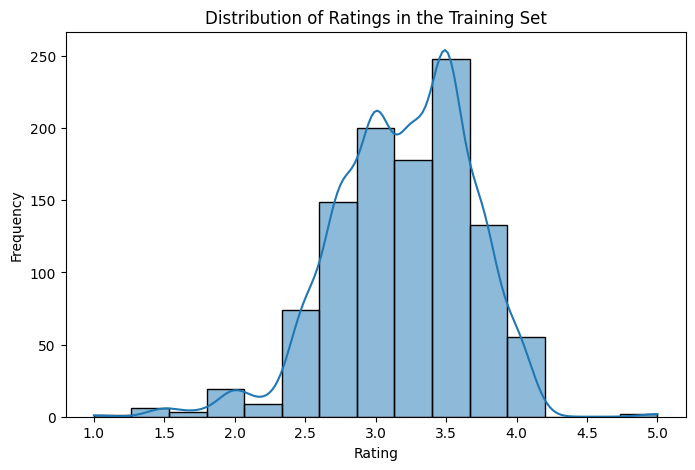

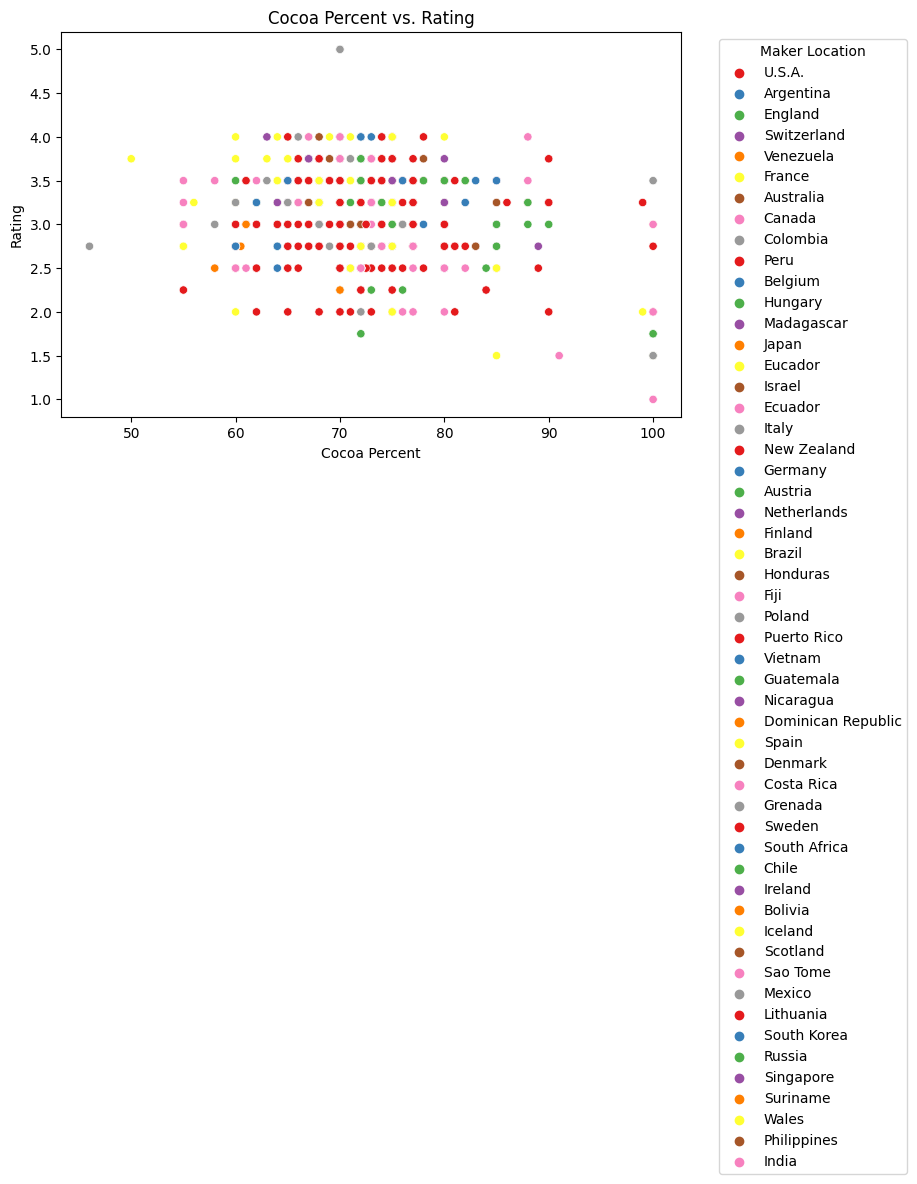

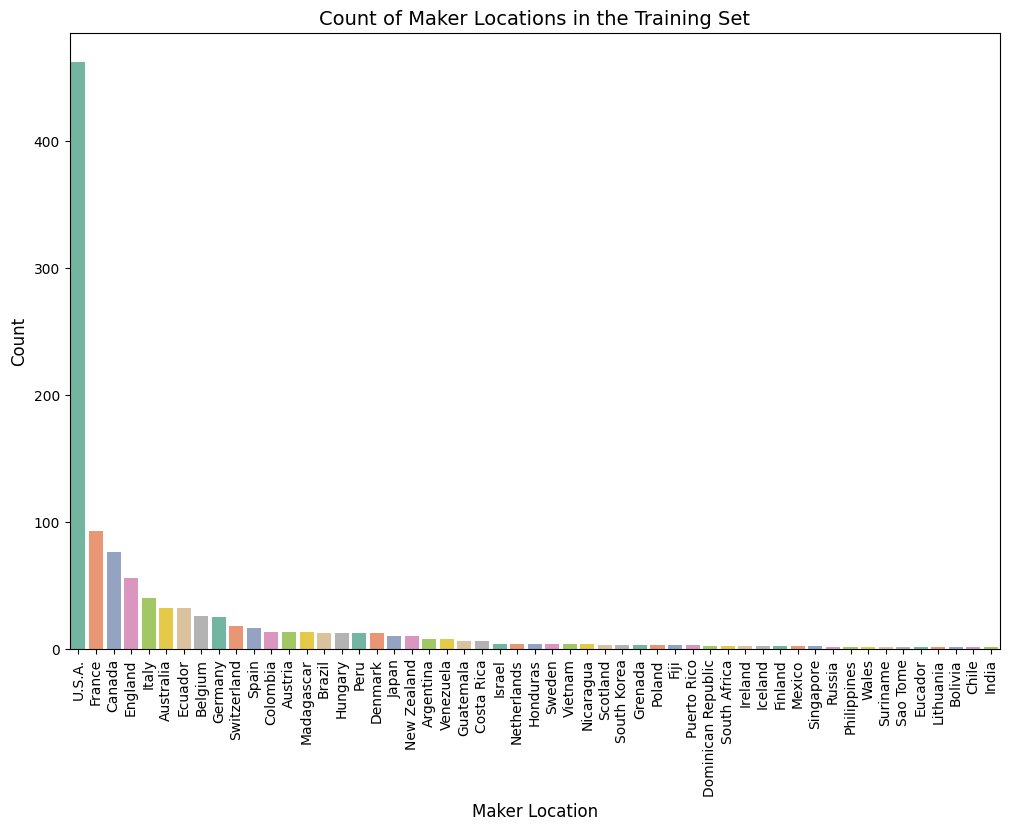

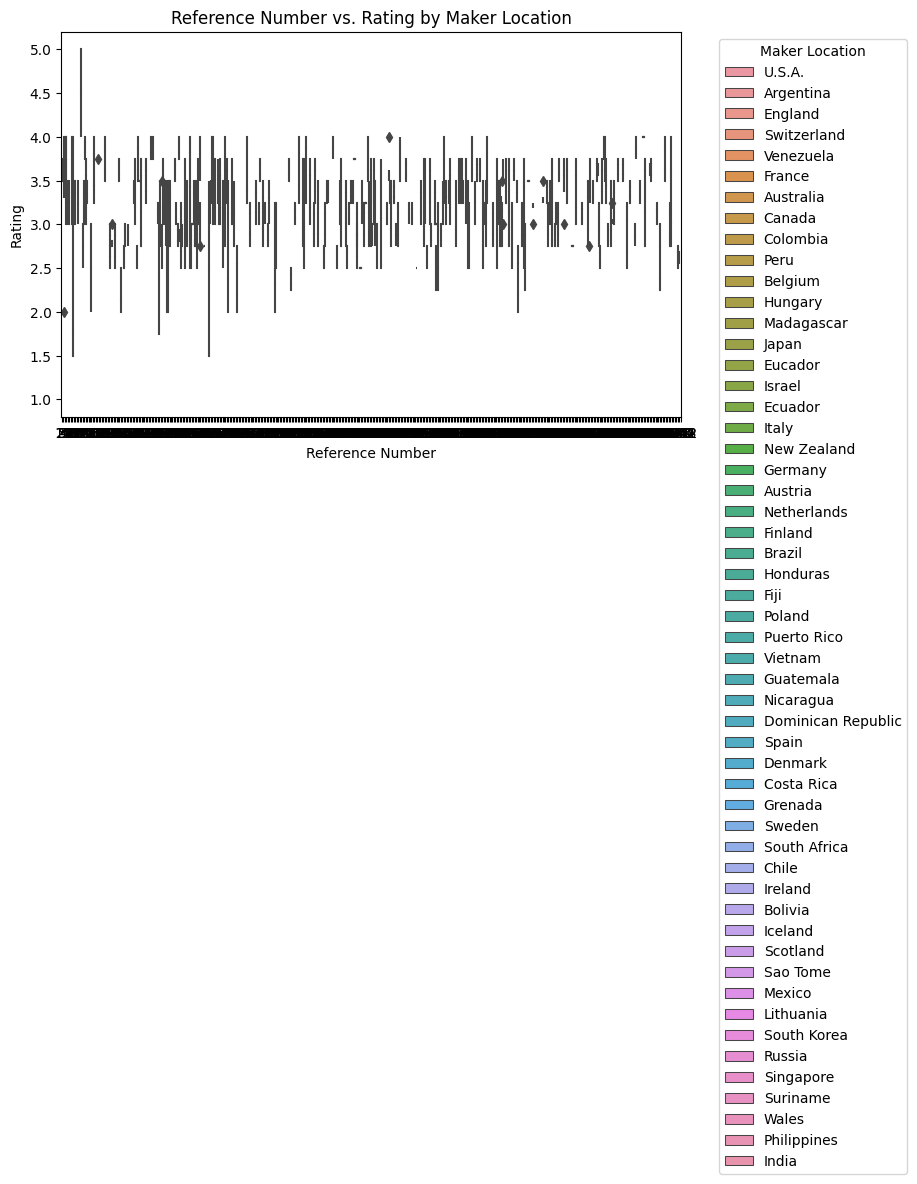

In [20]:
# YOUR CODE HERE

# Prepare the training data for visualization
X_train_viz = X_train.copy()
X_train_viz['maker_location'] = Y_train

# Plot 1: Distribution of Ratings in the training set
plt.figure(figsize=(8, 5))
sns.histplot(X_train_viz['rating'], kde=True, bins=15)
plt.title('Distribution of Ratings in the Training Set')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

# Plot 2: Cocoa Percent vs. Rating
plt.figure(figsize=(8, 5))
sns.scatterplot(data=X_train_viz, x='cocoa_percent', y='rating', hue='maker_location', palette='Set1')
plt.title('Cocoa Percent vs. Rating')
plt.xlabel('Cocoa Percent')
plt.ylabel('Rating')
plt.legend(title='Maker Location', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Plot 3: Count of Maker Locations in the Training Set
plt.figure(figsize=(12, 8))  # Increase figure size for better readability
sns.countplot(data=X_train_viz, x='maker_location', order=X_train_viz['maker_location'].value_counts().index, palette="Set2")
# Rotate x-axis labels for better visibility
plt.xticks(rotation=90, fontsize=10)
# Add title and labels
plt.title('Count of Maker Locations in the Training Set', fontsize=14)
plt.xlabel('Maker Location', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

# Plot 4: Reference Number vs. Rating by Maker Location
plt.figure(figsize=(8, 5))
sns.boxplot(data=X_train_viz, x='reference_number', y='rating', hue='maker_location')
plt.title('Reference Number vs. Rating by Maker Location')
plt.xlabel('Reference Number')
plt.ylabel('Rating')
plt.legend(title='Maker Location', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


**Distribution:** This distribution is fairly bell-shaped, with the majority of ratings between 2.5 and 4.0, peaking around 3.5.
The balanced distribution suggests that rating is a variable that could potentially help distinguish between different maker locations, though it's concentrated within a narrow range.

**Cocoa Percent vs. Rating by Maker Location** This plot shows the relationship between the cocoa percentage and the ratings, with different colors representing different maker locations. No strong correlation is immediately visible between cocoa percentage and rating, and the cocoa content seems fairly spread across maker locations. This shows that cocoa_percent alone may not be a strong predictor of the maker_location, but it could still be useful when combined with other features.

**Count of Maker Locations in the Training Set** This bar chart shows that countries, like the U.S.A., France, and Canada, dominate the dataset, while other locations have very few data points. This imbalance could lead to biased predictions, with the model potentially favoring larger classes like the U.S.A. and France. 

**Reference Number vs. Rating by Maker Location** The spread of ratings across different reference numbers suggests that reference_number alone might not directly predict the rating or maker location, but it could still contain some indirect information about the production process tied to certain maker locations.

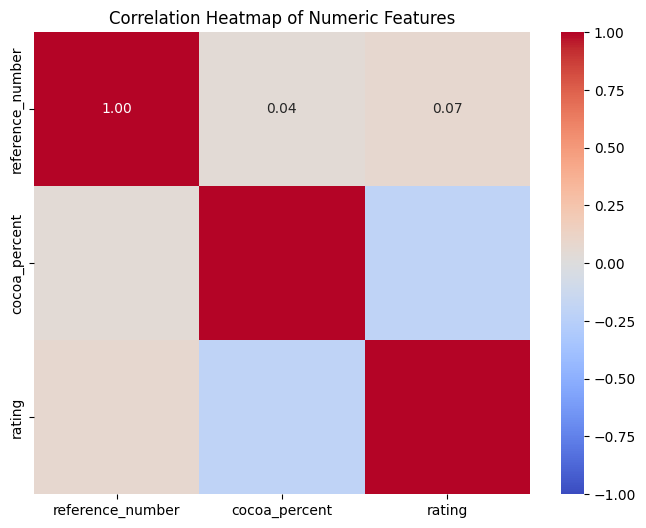

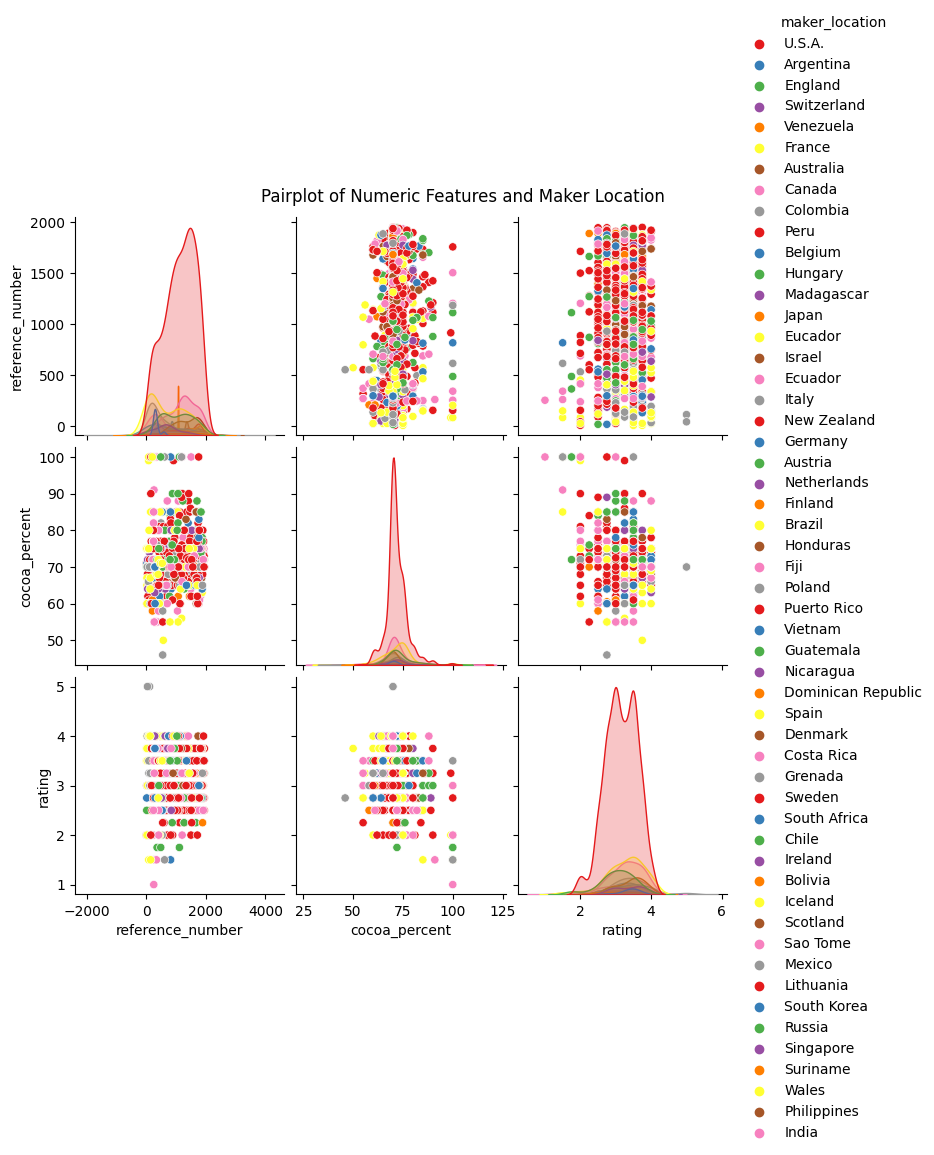

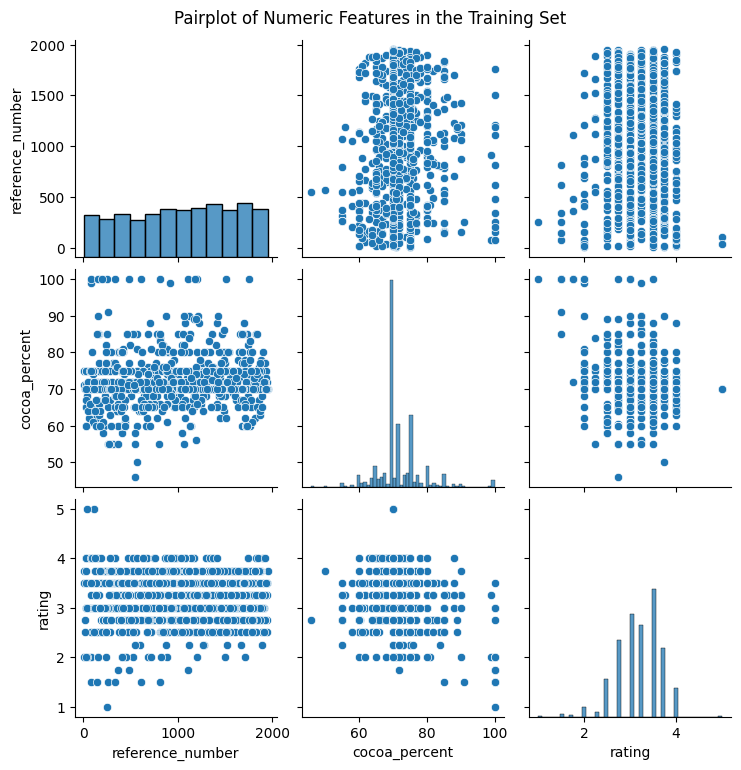

In [10]:
# Generate a correlation heatmap for the numeric features in the training set
plt.figure(figsize=(8, 6))
numeric_corr = X_train[numeric_features].corr()

# Heatmap for the correlation matrix
sns.heatmap(numeric_corr, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

# Pairplot for the numeric features and outcome (maker_location)
sns.pairplot(X_train_viz, vars=numeric_features, hue='maker_location', palette='Set1')
plt.suptitle('Pairplot of Numeric Features and Maker Location', y=1.02)
plt.show()

# Generate a pairplot with only the numeric features in the training dataset
sns.pairplot(X_train_viz, vars=numeric_features)
plt.suptitle('Pairplot of Numeric Features in the Training Set', y=1.02)
plt.show()


**Correlation Heatmap of Numeric Features** The correlation matrix indicates that reference_number, cocoa_percent, and rating have very low correlations with each other. There is a very weak positive correlation between cocoa_percent and rating, which suggests that higher cocoa content might result in slightly better ratings, but this is not a strong effect. Since these numeric features are weakly correlated, combining them with categorical features could provide more value for predicting maker_location.

**Pairplot of Numeric Features and Maker Location** The pairplot shows the distribution and relationships between numeric features, colored by maker locations. These plots show that the maker locations are spread across all numeric feature ranges, but some clustering can be observed in specific locations. Cocoa_percent and rating seem to show some patterns with certain maker locations, indicating that when combined, these features may help improve predictions.

In general, the visualizations above suggest that some numeric features like rating and cocoa_percent may help predict maker locations when combined with categorical features like specific_origin, bean_type, and broad_origin. It also shows some features, like reference_number, may not have a direct predictive impact but could contribute when used alongside other variables. The issue of the imbalanced distribution of maker locations would likely affect overall model predicatability power and accuracy.

---
### Step 4: Modeling

### <span style="color:chocolate">Exercise 5:</span> Baseline model (10 points)

When dealing with classification problems, a simple baseline is to select the *majority* class (the most common label in the training set) and use it as the prediction for all inputs.

1. Implement this baseline and report the accuracy metric on the train data;

2. Implement a function that computes the Log Loss (cross-entropy loss) metric and use it to evaluate this baseline on both the train and validation data. Note: reflect on what you know about the original distribution of classes in your training data (Hint: see Assignment 4 - Exercise 8 and ``Module Demos/05 Multiclass Logistic Regression.ipynb`` in bCourses for an example).

In [11]:
# YOUR CODE HERE

#1: Implement the majority class baseline and report accuracy on the training data

# Find the most common (majority) class in Y_train
unique_classes, class_counts = np.unique(Y_train, return_counts=True) 
majority_class = unique_classes[np.argmax(class_counts)]

# Make predictions using the majority class for all inputs in the training set
Y_train_baseline_pred = np.full_like(Y_train, majority_class) 

# Calculate accuracy of the majority class classifier on training data
train_accuracy = np.mean(Y_train == Y_train_baseline_pred) 

# Report the majority class and training accuracy
print(f"Majority class in Y_train: {majority_class}")
print(f"Accuracy of majority class classifier on Y_train: {train_accuracy:.4f}")


#2: Implement log loss function to evaluate this baseline on both training and validation data

# Corrected log loss function for multiclass classification
def log_loss_multiclass_correct(y_true, y_pred_prob, num_classes):
    epsilon = 1e-15  # To avoid log(0)
    y_pred_prob = np.clip(y_pred_prob, epsilon, 1 - epsilon)  # Clip predictions
    one_hot_true = np.eye(num_classes)[y_true]  
    
    loss = -np.mean(np.sum(one_hot_true * np.log(y_pred_prob), axis=1))  # Multiclass log loss
    return loss

"""# Convert categorical labels (maker_location) to integer indices using LabelEncoder
label_encoder = LabelEncoder()

# Fit the label encoder on the unique classes in the training data
Y_train_encoded = label_encoder.fit_transform(Y_train_numpy)

# Handle unseen labels in validation set by assigning them a new class (optional)
Y_val_encoded = np.array([label_encoder.transform([val])[0] if val in label_encoder.classes_ else -1 for val in Y_val_numpy])"""

# Number of unique classes (needed for one-hot encoding)
num_classes = len(unique_classes)

# creating a matrix of probabilities for baseline predictions
# The majority class will have probability close to 1, while others will have low probabilities.
epsilon = 1e-15
train_pred_prob = np.full((len(Y_train), num_classes), epsilon) 
val_pred_prob = np.full((len(Y_val), num_classes), epsilon) 

# Set the probability of the majority class to 1 - epsilon
majority_class_index = np.where(unique_classes == majority_class)[0][0]
train_pred_prob[:, majority_class_index] = 1 - epsilon
val_pred_prob[:, majority_class_index] = 1 - epsilon

# Recalculate log loss for training and validation sets using the corrected multiclass function
train_log_loss = log_loss_multiclass_correct(Y_train_encoded, train_pred_prob, num_classes)
val_log_loss = log_loss_multiclass_correct(Y_val_encoded[Y_val_encoded != -1], val_pred_prob[Y_val_encoded != -1], num_classes)

# Output the corrected results
print(f"Multiclass Log Loss on Y_train (majority baseline): {train_log_loss:.4f}")
print(f"Multiclass Log Loss on Y_val (majority baseline): {val_log_loss:.4f}")

# Reflect on class distribution in training data
print(f"Distribution of classes in Y_train: {dict(zip(unique_classes, class_counts))}")

Majority class in Y_train: U.S.A.
Accuracy of majority class classifier on Y_train: 0.4290
Multiclass Log Loss on Y_train (majority baseline): 19.7227
Multiclass Log Loss on Y_val (majority baseline): 20.2536
Distribution of classes in Y_train: {'Argentina': 8, 'Australia': 32, 'Austria': 13, 'Belgium': 26, 'Bolivia': 1, 'Brazil': 12, 'Canada': 76, 'Chile': 1, 'Colombia': 13, 'Costa Rica': 6, 'Denmark': 12, 'Dominican Republic': 2, 'Ecuador': 32, 'England': 56, 'Eucador': 1, 'Fiji': 3, 'Finland': 2, 'France': 93, 'Germany': 25, 'Grenada': 3, 'Guatemala': 6, 'Honduras': 4, 'Hungary': 12, 'Iceland': 2, 'India': 1, 'Ireland': 2, 'Israel': 4, 'Italy': 40, 'Japan': 10, 'Lithuania': 1, 'Madagascar': 13, 'Mexico': 2, 'Netherlands': 4, 'New Zealand': 10, 'Nicaragua': 4, 'Peru': 12, 'Philippines': 1, 'Poland': 3, 'Puerto Rico': 3, 'Russia': 1, 'Sao Tome': 1, 'Scotland': 3, 'Singapore': 2, 'South Africa': 2, 'South Korea': 3, 'Spain': 16, 'Suriname': 1, 'Sweden': 4, 'Switzerland': 18, 'U.S.A.': 

### <span style="color:chocolate">Exercise 6:</span> Improvement over baseline with Tensorflow (10 points)

Use TensorFlow (TF) to train a multiclass logistic regression model much like you did in Assignment 4. The goal here is to build a ML model to improve over the baseline classifier. You have the flexibility to choose which features to include.

With this in mind, complete the following tasks:

1. Build and compile a multiclass classification TF model (call it model_tf). Hint: the activation function, the loss, and the evaluation metric are different compared to the binary logistic regression (see ``Module Demos/05 Multiclass Logistic Regression.ipynb`` in bCourses for an example). Set learning_rate = 0.0001 and optimizer = SGD.
2. Train model_tf using the training dataset and pass the validation data for validation. Set num_epochs = 10 and batch_size = 32.
3. Generate a plot (for the training and validation data) with the loss values on the y-axis and the epoch number on the x-axis for visualization. Make sure to include axes name and title.

If instructions for any other hyperparameters are not provided here, you are free to select your own or use the default settings.

In [12]:
# YOUR CODE HERE

# multiclass classification TF model
def build_model_multiclass(num_features, num_classes, learning_rate):
    """Build a multiclass TF logistic regression model using Keras."""
    
    # Clear any previous models and set the random seed
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)
    
    # Build a model using keras.Sequential
    model = tf.keras.Sequential()
    
    # Add a single dense layer for multiclass classification
    model.add(tf.keras.layers.Dense(
        units=num_classes,                # Number of output classes
        input_shape=(num_features,),      # Input shape
        activation="softmax"              # softmax activation for multiclass
    ))
    
    # Use the SGD optimizer with the specified learning rate
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    
    # Compile the model with categorical cross-entropy loss and accuracy metric
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',  # Loss function for integer-encoded labels
                  metrics=['accuracy'])                   #accuracy to evaluate performance
    
    return model

Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0270 - loss: 3.9666 - val_accuracy: 0.0340 - val_loss: 3.9665
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0270 - loss: 3.9656 - val_accuracy: 0.0340 - val_loss: 3.9655
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0276 - loss: 3.9645 - val_accuracy: 0.0340 - val_loss: 3.9645
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0272 - loss: 3.9635 - val_accuracy: 0.0340 - val_loss: 3.9635
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0291 - loss: 3.9624 - val_accuracy: 0.0340 - val_loss: 3.9624
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0295 - loss: 3.9614 - val_accuracy: 0.0340 - val_loss: 3.9614
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0301 - loss: 3.9603 - val_accuracy: 0.0340 - val_loss: 3.9604
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0338 - loss: 3.9593 - val_accuracy: 0.0340 - val_loss:

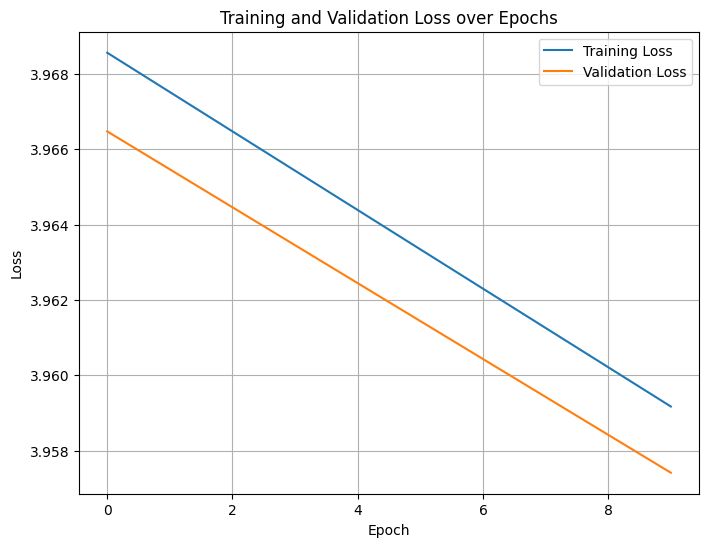

In [13]:
# Set parameters for the model
num_features = X_train_prepared.shape[1]  # Number of input features
num_classes = len(np.unique(Y_train_encoded))  # Number of output classes (unique maker locations)
learning_rate = 0.0001

# Build the model
model_tf = build_model_multiclass(num_features=num_features, num_classes=num_classes, learning_rate=learning_rate)

# Task 2: Train the model

# Filter out samples with labels equal to -1 in the validation and test sets
valid_val_indices = Y_val_encoded != -1
valid_test_indices = Y_test_encoded != -1

# Apply filtering to both X and Y for validation and test sets
X_val_filtered = X_val_prepared[valid_val_indices]
Y_val_filtered = Y_val_encoded[valid_val_indices]

X_test_filtered = X_test_prepared[valid_test_indices]
Y_test_filtered = Y_test_encoded[valid_test_indices]

# Set training parameters
num_epochs = 10
batch_size = 32

# Train the model and store the history for visualization
history = model_tf.fit(X_train_prepared, Y_train_encoded,
                       epochs=num_epochs,
                       batch_size=batch_size,
                       validation_data=(X_val_filtered, Y_val_filtered), #X_val_prepared, Y_val_encoded
                       verbose=1)

# Task 3: Generate plot for training and validation loss

# Plot the training and validation loss over epochs
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

---
### Step 5: Hyperparameter tuning

### <span style="color:chocolate">Exercise 7:</span> Choosing hyperparameters (10 points)

1. Fine-tune the **learning rate**, **number of epochs**, and **batch size** hyperparameters of *model_tf* to determine the setup that yields the most optimal generalization performance. Feel free to explore various values for these hyperparameters. Hint: you can manually test different hyperparameter values or you can use the [Keras Tuner](https://www.tensorflow.org/tutorials/keras/keras_tuner). 

After identifying your preferred model configuration, print the following information:

2. The first five learned parameters of the model (this should include the bias term);
3. The loss at the final epoch on both the training and validation datasets;
4. The percentage difference between the losses observed on the training and validation datasets.
5. Compare the training/validation loss of the TensorFlow model (model_tf) with the baseline model's loss. Does the TensorFlow model demonstrate an improvement over the baseline model?

In [14]:
# YOUR CODE HERE

# Fine-tune hyperparameters for the best model
learning_rates = [0.01, 0.3]  # Trying a few learning rates
epochs_options = [20, 60]  # Trying different numbers of epochs

# Placeholder for the best configuration
best_model = None
best_train_loss = None
best_val_loss = None
best_history = None

# Build and train the model for each combination of learning rate and epochs
for lr in learning_rates:
    for num_epochs in epochs_options:
        print(f"\nTraining model with learning_rate={lr} and epochs={num_epochs}")
        
        # Build the model with the current configuration
        model_tf = build_model_multiclass(num_features, num_classes, learning_rate=lr)
        
        # Train the model
        history = model_tf.fit(X_train_prepared, Y_train_encoded,
                               epochs=num_epochs,
                               batch_size=32,
                               validation_data=(X_val_filtered, Y_val_filtered),
                               verbose=1)
        
        # Get the final training and validation loss
        final_train_loss = history.history['loss'][-1]
        final_val_loss = history.history['val_loss'][-1]
        
        # Check if this is the best validation loss so far
        if best_val_loss is None or final_val_loss < best_val_loss:
            best_model = model_tf
            best_train_loss = final_train_loss
            best_val_loss = final_val_loss
            best_history = history
            best_lr = lr
            best_epochs = num_epochs

# Print the best model configuration and corresponding losses
print(f"\nBest model: learning_rate={best_lr}, epochs={best_epochs}")
print(f"Training loss: {best_train_loss}")
print(f"Validation loss: {best_val_loss}")



Training model with learning_rate=0.01 and epochs=20
Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0434 - loss: 3.9591 - val_accuracy: 0.2380 - val_loss: 3.8921
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2828 - loss: 3.8555 - val_accuracy: 0.3994 - val_loss: 3.7941
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4220 - loss: 3.7541 - val_accuracy: 0.4136 - val_loss: 3.6988
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4340 - loss: 3.6555 - val_accuracy: 0.4136 - val_loss: 3.6066
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4346 - loss: 3.5601 - val_accuracy: 0.4136 - val_loss: 3.5181
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4346 - loss: 3.4684 - val_accuracy: 0.4136 - val_loss: 3.4338
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4346 - loss: 3.3810 - val_accuracy: 0.4136 - val_loss: 3.3543
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.

In [15]:
# 1. First five learned parameters of the model
weights, bias = best_model.layers[0].get_weights()
print("First five learned parameters (weights):", weights.flatten()[:5])
print("Bias term:", bias[:5])

# 2. The loss at the final epoch on both the training and validation datasets
print("Final Training Loss:", best_train_loss)
print("Final Validation Loss:", best_val_loss)

# 3. Percentage difference between training and validation losses
percentage_difference = 100 * abs(best_val_loss - best_train_loss) / best_train_loss
print(f"Percentage difference between training and validation loss: {percentage_difference:.2f}%")

# 4. Compare the training/validation loss with the baseline model's loss
baseline_train_loss = train_log_loss  # Use previously computed log loss for the baseline
baseline_val_loss = val_log_loss

print(f"Improvement over baseline training loss: {baseline_train_loss - best_train_loss:.6f}")
print(f"Improvement over baseline validation loss: {baseline_val_loss - best_val_loss:.6f}")

if best_train_loss < baseline_train_loss and best_val_loss < baseline_val_loss:
    print("The TensorFlow model demonstrates an improvement over the baseline.")
else:
    print("The TensorFlow model does not demonstrate an improvement over the baseline.")

First five learned parameters (weights): [-0.08758307 -0.03113662  0.00893602 -0.01575833 -0.01563985]
Bias term: [-0.11164173  1.1349057   0.87166333  1.2205741  -0.8028798 ]
Final Training Loss: 0.583737313747406
Final Validation Loss: 1.116716742515564
Percentage difference between training and validation loss: 91.30%
Improvement over baseline training loss: 19.138962
Improvement over baseline validation loss: 19.136900
The TensorFlow model demonstrates an improvement over the baseline.


The tensorflow model does demonstrate significant improvement over the baseline model

---
### Step 6: Evaluation and generalization

### <span style="color:chocolate">Exercise 8:</span> Compute metrics (10 points)

Now that you've determined the optimal set of hyperparameters, it's time to evaluate your optimized model on the test data to gauge its performance in real-world scenarios, commonly known as inference.

1. Calculate aggregate accuracy on both train and test datasets. Note: you will need to convert the vector of predicted probabilities to a class label using the argmax operation. Hint: You can utilize the <span style="color:chocolate">model.predict()</span> method provided by tf.keras. and the <span style="color:chocolate">np.max()</span> method available in NumPy.

2. Does the model demonstrate strong aggregate generalization capabilities? Provide an explanation based on your accuracy observations.

In [16]:
# YOUR CODE HERE
# 1. Calculate accuracy on the training dataset
# Getting the predicted probabilities for the training set
train_predictions_prob = best_model.predict(X_train_prepared)

# Convert probabilities to class labels using np.argmax
train_predictions_class = np.argmax(train_predictions_prob, axis=1)

# Calculate training accuracy by comparing with the true labels
train_accuracy = np.mean(train_predictions_class == Y_train_encoded)
print(f"Training Accuracy: {train_accuracy:.4f}")

# 2. Calculate accuracy on the test dataset
# Get the predicted probabilities for the test set
test_predictions_prob = best_model.predict(X_test_filtered)

# Convert probabilities to class labels using np.argmax
test_predictions_class = np.argmax(test_predictions_prob, axis=1)

# Calculate test accuracy by comparing with the true labels
test_accuracy = np.mean(test_predictions_class == Y_test_filtered)
print(f"Test Accuracy: {test_accuracy:.4f}")

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Training Accuracy: 0.8858
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Test Accuracy: 0.7087


The model does not demonstrate strong generalization capabilities since its test accuracy is much lower compared to the training accuracy. The gap between training and test accuracy suggests the model may be overfitting to the training data. This means it learned specific patterns in the training data that do not generalize well to the test set.

### <span style="color:chocolate">Exercise 9:</span> Additional metrics (10 points)

Using the test dataset:

1. Plot the confusion matrix. Identify which class the model confuses the most.

2. Determine which class has the lowest precision. What is the precision? Which class is the largest source of false positives?

3. Determine which class has the lowest recall. What is the recall? Which class is the largest source of false negatives?

<Figure size 1500x1200 with 0 Axes>

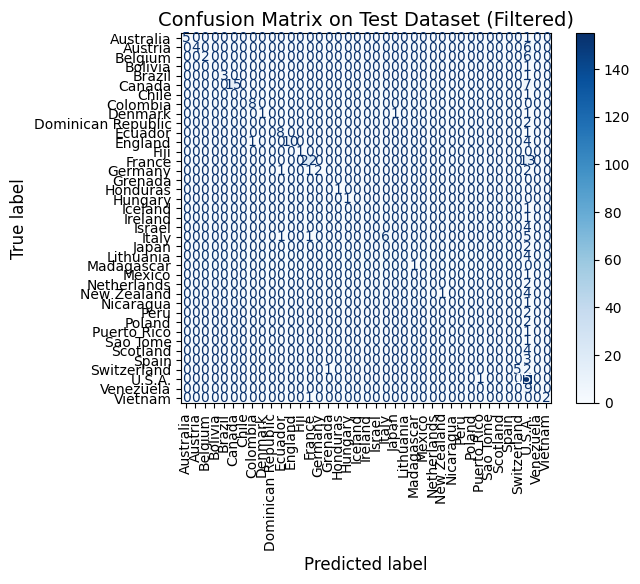

Class with the lowest precision: Bolivia with precision: 0.0000
Class with the largest source of false positives: Bolivia
Class with the lowest recall: Bolivia with recall: 0.0000
Class with the largest source of false negatives: Bolivia


In [17]:
# YOUR CODE HERE
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. Confusion Matrix
# Generate the confusion matrix
cm = confusion_matrix(Y_test_filtered, test_predictions_class)

# Get the unique classes present in both actual labels and predictions
unique_classes_in_test = np.unique(np.concatenate((Y_test_filtered, test_predictions_class)))

# Ensure that the number of unique classes matches the size of the confusion matrix
assert cm.shape[0] == len(unique_classes_in_test), "Mismatch between confusion matrix and number of unique classes"

# Get the actual class labels (names) for these unique classes
unique_class_names = label_encoder.inverse_transform(unique_classes_in_test)

# Plot confusion matrix with matching labels
plt.figure(figsize=(15, 12))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_class_names)
disp.plot(cmap='Blues')
plt.xticks(rotation=90, fontsize =10)  # Rotate the x-axis labels for better visibility
plt.title("Confusion Matrix on Test Dataset (Filtered)", fontsize= 14)
plt.xlabel("Predicted label", fontsize=12)
plt.ylabel("True label", fontsize=12)
plt.show()

# 2. Precision and Recall per Class
# Generate the classification report (precision, recall, F1-score) for each class in the test set
report = classification_report(Y_test_filtered, test_predictions_class, labels=unique_classes_in_test, output_dict=True)

# Find the class with the lowest precision and recall
lowest_precision_class = min(report, key=lambda x: report[x]['precision'] if x.isdigit() else float('inf'))
lowest_precision_value = report[lowest_precision_class]['precision']

lowest_recall_class = min(report, key=lambda x: report[x]['recall'] if x.isdigit() else float('inf'))
lowest_recall_value = report[lowest_recall_class]['recall']

# Output precision and recall information for the test dataset
lowest_precision_class_name = label_encoder.classes_[int(lowest_precision_class)]
lowest_recall_class_name = label_encoder.classes_[int(lowest_recall_class)]

print(f"Class with the lowest precision: {lowest_precision_class_name} with precision: {lowest_precision_value:.4f}")
print(f"Class with the largest source of false positives: {lowest_precision_class_name}")

print(f"Class with the lowest recall: {lowest_recall_class_name} with recall: {lowest_recall_value:.4f}")
print(f"Class with the largest source of false negatives: {lowest_recall_class_name}")

----
#### <span style="color:chocolate">Additional practice question</span> (not graded)

Following the approach in Assignment 4 - Exercise 12, evaluate whether your model shows any signs of unfairness. Explain your findings and propose suggestions for improvement.

In [18]:
# YOUR CODE HERE

From the confusion matrix, France, U.S.A. have significantly higher correct predictions compared to others like Lithuania, Madagascar etc. which have very few or no correct predictions. Underrepresented Classes or those with fewer correct predictions (like Dominican Republic, Sao Tome, and others) indicates that the model is biased towards more frequent classes, like U.S.A. or France. This imbalance could be seen from the exploratory viz distribution as USA and France were well represented in the dataset. So it seems the bias and unfairness stems from imbalanced data, where the model has learned to favor classes with more samples during training.

**Proposal for improvements** 
- We can use techniques like oversampling underrepresented classes such as Lithuania, Madagascar or undersampling overrepresented classes ( U.S.A., France) to create a more balanced dataset. This way, the model learns equally from all classes.
- Incorporate class weights during model training. This penalizes misclassifications of underrepresented classes more heavily, encouraging the model to focus on these minority classes.